## Data ##

This analysis implements random forest classifier to predict direction of crypto currencies. The model is trained for nine crypto currencies, using technical and momentum features, to forecast the direction on the next day. The model is trained on the last one year of daily data and the model is used for next one month to forecast direction on a daily basis. The accuracy of the model varies from 55% to 60%. However, the backtest result shows modest profitability along with high daily volume. The model accuracy can be enhanced by incorporating additional features specific to cryto currencies. However due to lack of additional data, we focused on only technical features.   

## Data Universe ##

The data set contains minutely Open, High, Low, Close and Volume data for 429 cryocurrency pairs.  The data series starts from 01-Apr-2013 for **btcusd** which by far the most traded pair and has the highest liquidity and largest amount of data available.

We used following filtering to select liquid cryptocurrency pairs which have sufficient history of data available for the analysis.

1. We selected top 100 cryocurrency pairs based on the number of rows in the data file.
2. We excluded all the cryocurrency pairs having start date after 1 Jan 2018.
3. We removed all the cryocurrency pairs having average daily turnover below 5m $.

This filtering gives us following list of cryptocurrency pairs for further analysis.
1. xrpusd
2. ethusd
3. btcusd
4. eosusd
5. btceur
6. ethbtc
7. iotusd
8. neousd
9. ltcusd

In [1]:
\l ml/ml.q
.ml.loadfile`:init.q;
\l utils/util.q
\l utils/graphics.q

In [2]:
//Count number of rows in each files from data folder for selecting top 50 cryptocurrency
dataDirPath: hsym[`$"data/"];
files: key dataDirPath;
rowCountTbl: {[path;file] 
    n:count read0 ` sv path,file; 
    :([] file:enlist file;rowcount:n)}[dataDirPath;] each files;
rowCountTbl:`rowcount xdesc raze rowCountTbl;

In [3]:
show 5#rowCountTbl;

file       rowcount
-------------------
btcusd.csv 3691472 
ethusd.csv 2474411 
ltcusd.csv 2315790 
xrpusd.csv 2133169 
ethbtc.csv 1843441 


In [4]:
//Filter 1: select top 100 instruments by row count for further analysis
files:100#rowCountTbl[`file];

In [5]:
//load data for top 100 instruments in priceDataTbl
loadFile: {[path;file]
    -1"processing file: ", string[file];
    symbol : first[` vs file];
    :update sym:symbol, time:1970.01.01+0D00:00:00.001*time from ("JFFFFF";enlist csv) 0: ` sv path,file;
    };
priceDataTbl: `sym`time xcols raze loadFile[dataDirPath;] each files;

processing file: btcusd.csv
processing file: ethusd.csv
processing file: ltcusd.csv
processing file: xrpusd.csv
processing file: ethbtc.csv
processing file: eosusd.csv
processing file: btceur.csv
processing file: iotusd.csv
processing file: ltcbtc.csv
processing file: etcusd.csv
processing file: neousd.csv
processing file: omgusd.csv
processing file: zecusd.csv
processing file: xrpbtc.csv
processing file: dshusd.csv
processing file: leousd.csv
processing file: ustusd.csv
processing file: xmrusd.csv
processing file: eosbtc.csv
processing file: etheur.csv
processing file: iotbtc.csv
processing file: btcjpy.csv
processing file: btcust.csv
processing file: btcgbp.csv
processing file: omgbtc.csv
processing file: etcbtc.csv
processing file: trxusd.csv
processing file: ethust.csv
processing file: xmrbtc.csv
processing file: zecbtc.csv
processing file: dshbtc.csv
processing file: ethjpy.csv
processing file: bsvusd.csv
processing file: etpusd.csv
processing file: neobtc.csv
processing file: xtz

In [6]:
// convert minutely price data into daily data
dailyTbl:select first open, max high, min low, last close, sum volume by sym, date:`date$time from priceDataTbl;

In [7]:
// Filter out syms with start date after 2018.01.01
symsSdFilter: exec distinct sym from dailyTbl where 2018.01.01>(min;date) fby sym;
// Filter out syms with avg turnover below 5m assuming 1USD ~ 1 EUR
symsTurnoverFilter: exec distinct sym from dailyTbl where 5000000 < (avg;close*volume) fby sym;
// select syms based on start date and turnover filter
syms: symsSdFilter inter symsTurnoverFilter;
show syms;

`btceur`btcusd`eosusd`etcusd`ethusd`iotusd`ltcusd`neousd`xrpusd


In [8]:
//Only store the data of the selected cryptocurrencies
dailyTbl: select from dailyTbl where sym in syms;
show dailyTbl;

sym    date      | open     high     low      close    volume  
-----------------| --------------------------------------------
btceur 2017.05.19| 1775.952 1775.952 1775.952 1775.952 0.01    
btceur 2017.05.21| 1877     1877.3   1789.413 1809.3   418.9884
btceur 2017.05.22| 1810.2   1977.445 1764     1812.643 15690.64
btceur 2017.05.23| 1889.274 2012.9   1872     2000.6   495.3617
btceur 2017.05.24| 2009.2   2179.6   2009.2   2137.2   1235.256
btceur 2017.05.25| 2128.4   2398.4   1926     2022.7   1732.667
btceur 2017.05.26| 2022.7   2158.2   1881.5   1883.3   536.9242
btceur 2017.05.27| 1635.721 1635.721 1619.456 1619.456 0.02    
btceur 2017.05.28| 1914.266 1941.9   1913.5   1941.9   15.67266
btceur 2017.05.29| 1905.4   2008.4   1872.2   1962.2   436.2522
btceur 2017.05.30| 1987.8   2026.9   1859.8   1908.1   1326.21 
btceur 2017.05.31| 1920.3   1995.6   1789.3   1950.9   2546.852
btceur 2017.06.01| 1950.7   2108.2   1950.7   2058.5   2025.848
btceur 2017.06.02| 2062.6   2140.2   201

## Data Visualization ##

### Plot daily prices for staring Jan 2018  ###

In [9]:
// @functionoverview Plot daily close prices for the specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {null} 
plotCryptoDaily:{[symbol;sd;ed] 
    data:select from dailyTbl where date within (sd;ed), sym=symbol;
    data:select last close by date from data ;
    data:flip 0!data;
    .util.plotTimeSeriesSubplots[data[`date];data[`close];string[symbol]];};

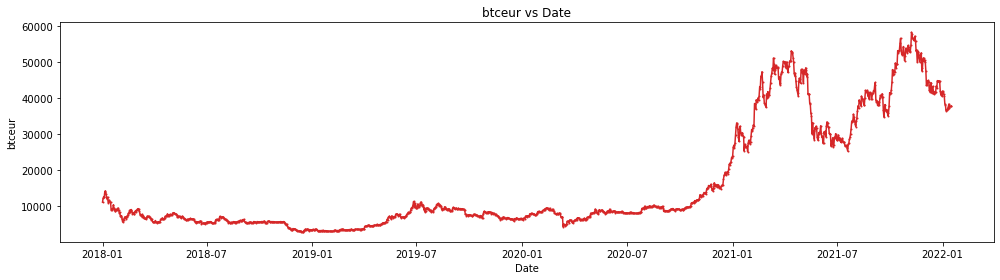

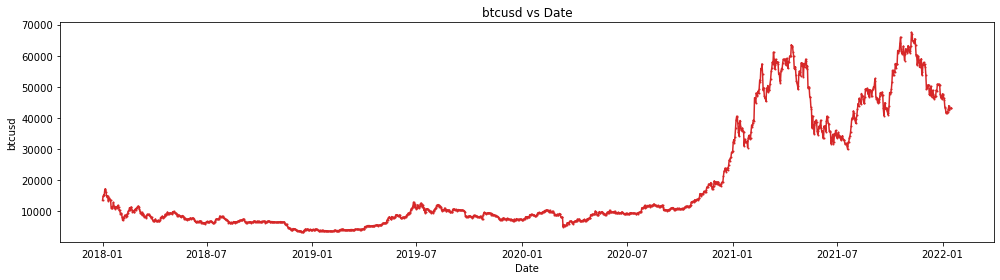

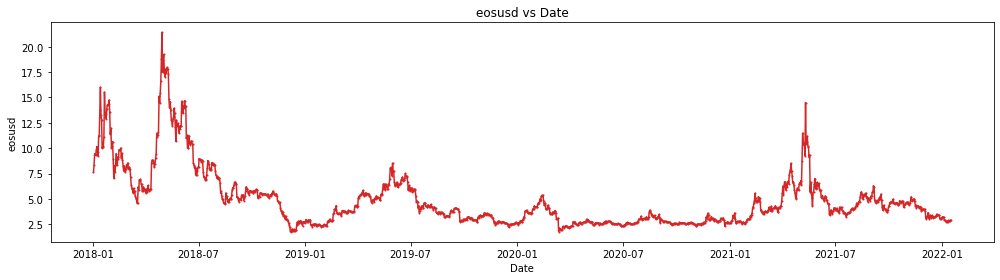

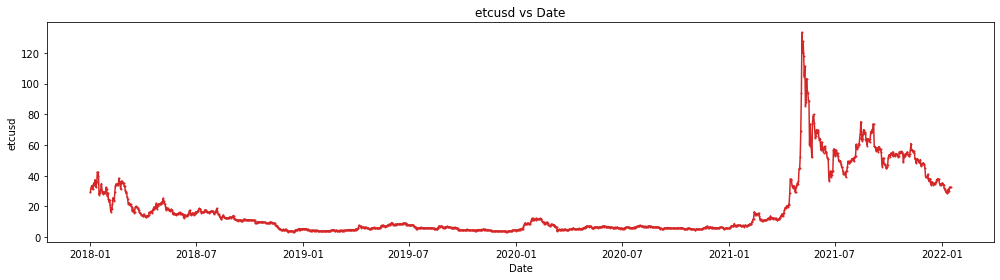

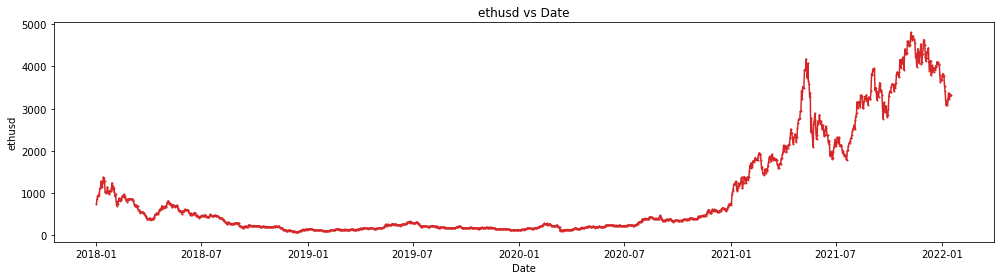

In [10]:
//Plot daily price chart of top 5 the selected cryptocurrency pairs
plotCryptoDaily[;2018.01.01;.z.D] each 5#syms;

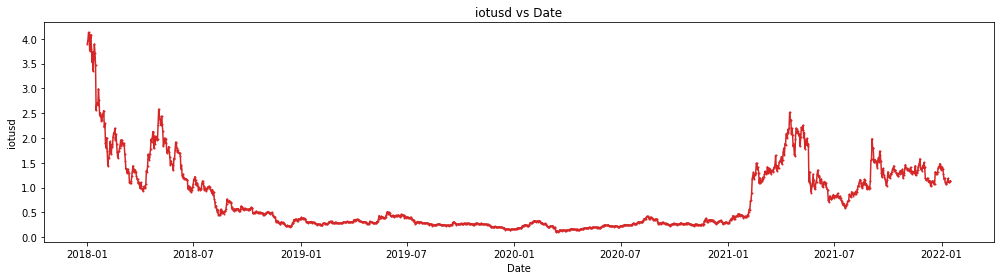

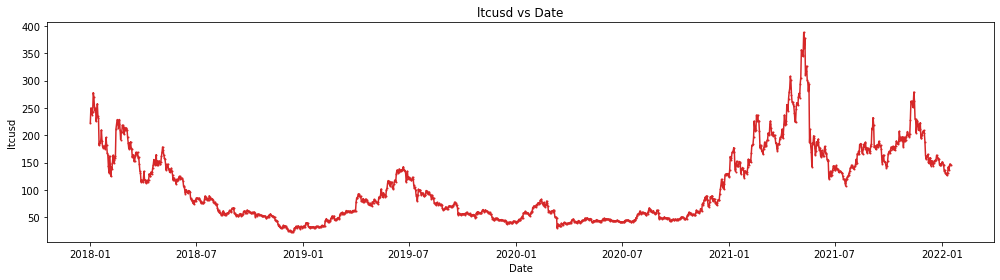

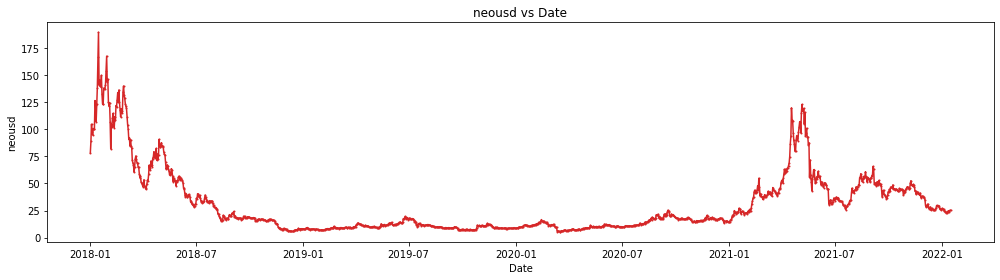

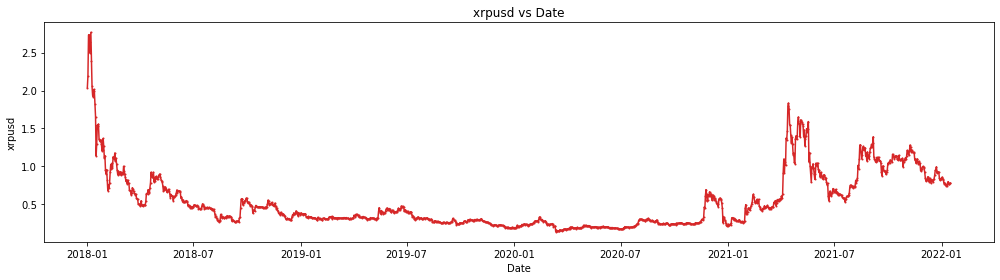

In [11]:
//Plot daily price chart of last 4 the selected cryptocurrency pairs
plotCryptoDaily[;2018.01.01;.z.D] each -4#syms;

## Cross Correlation ##

### Cross correlation ###

In [12]:
// @functionoverview Computes daily log return of the specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl}  daily log return keyed by date
getDailyReturn:{[symbol;sd;ed] 
    data:select from dailyTbl where date within (sd;ed), sym=symbol;
    data:update ret1d:log[close%prev close] from data;
    data:`date xkey (`date;symbol) xcol select date, ret1d from data;
    :1_data;};

In [13]:
// @functionoverview Computes cross correlation of symbols specified using daily returns  
// @param syms {list} list of cryptocurrency symbols
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl}  cross correlation table
computeCrossCorr:{[syms;sd;ed]
    retTbl:(lj/)getDailyReturn[;sd;ed] each syms;
    cyptocorr:r cor/:\:r:(enlist `date) _flip 0!retTbl;
    cyptocorr:`sym xkey update sym: key cyptocorr from value flip cyptocorr;
    :cyptocorr;};

#### Cross correlation of daily return   ####

#### Year 2018   ####

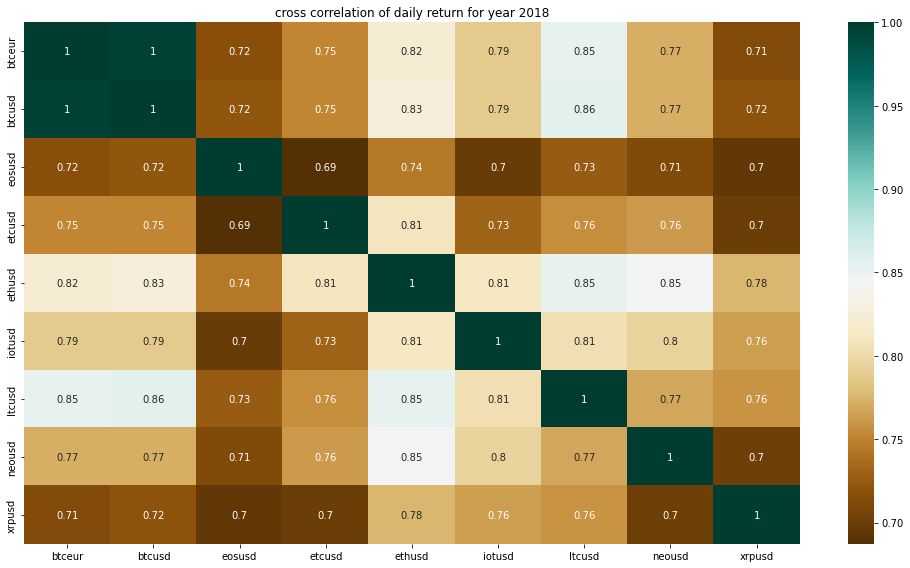

In [14]:
cyptocorr:computeCrossCorr[syms;2018.01.01;2018.12.31];
.util.plotHeatMap[cyptocorr;"cross correlation of daily return for year 2018"];

#### year 2019   ####

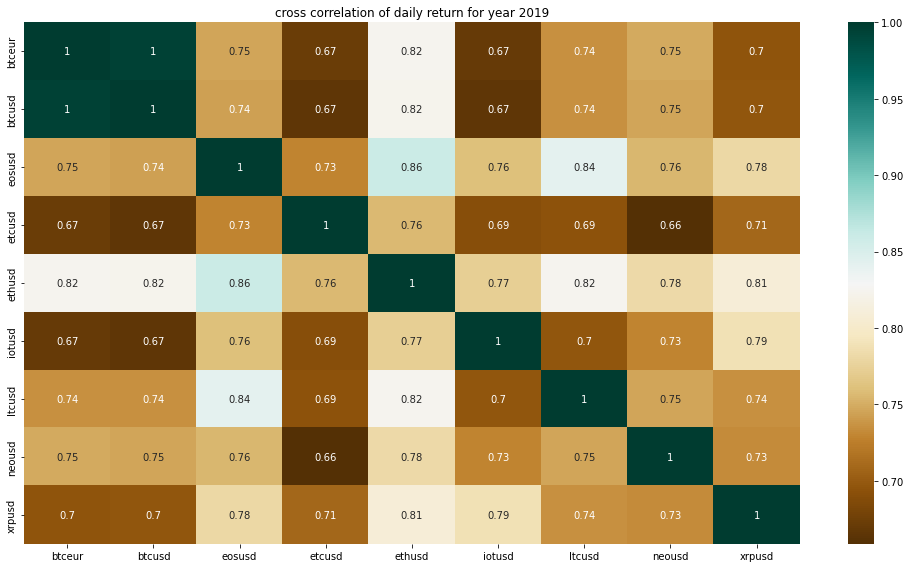

In [15]:
cyptocorr:computeCrossCorr[syms;2019.01.01;2019.12.31];
.util.plotHeatMap[cyptocorr;"cross correlation of daily return for year 2019"];

##### Observation: ######
There is a significant cross-correlation between multiple pairs of crypto currencies.

### Auto correlation of daily return ###

In [16]:
//compute daily return for ploting ACF
retTbl:(lj/)getDailyReturn[;2018.01.01;2018.12.31] each syms;
retTbl:(enlist `date) _flip 0!retTbl;

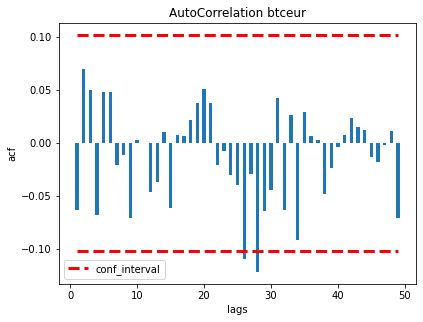

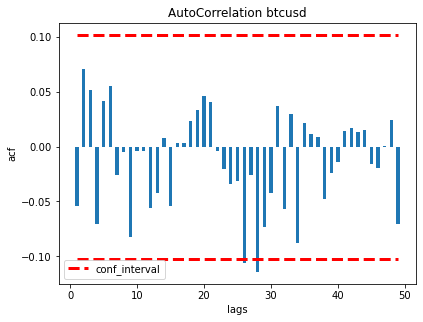

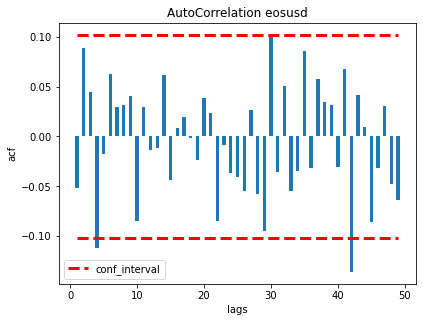

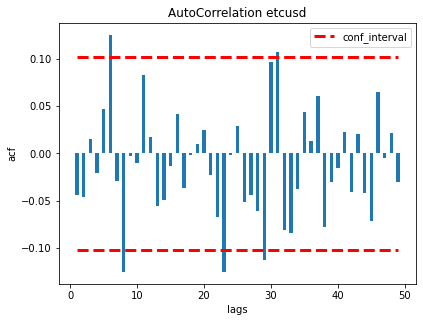

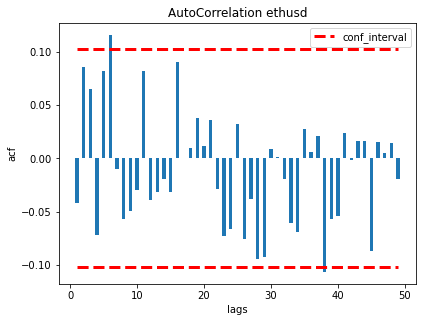

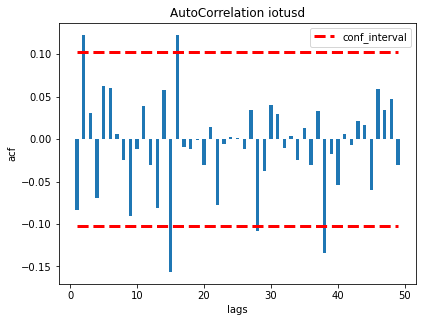

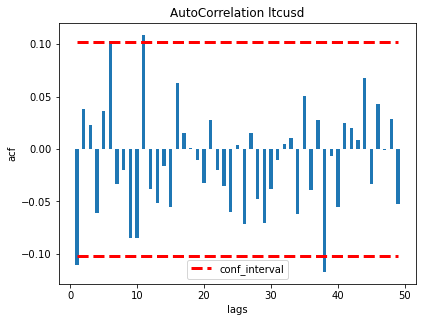

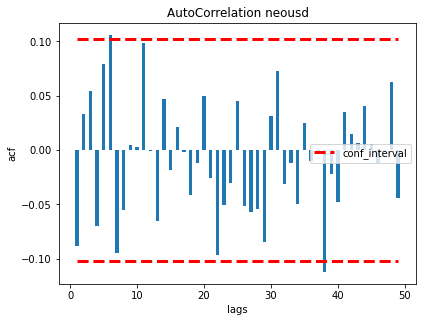

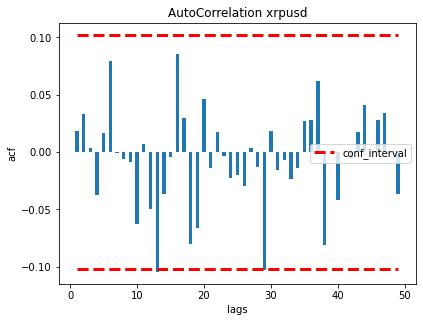

In [17]:
// plot acf for all crypto currencies
{.ml.ts.acfPlot[retTbl x;50;1; string[x]]} each syms;

### Partial Auto correlation of daily return ###

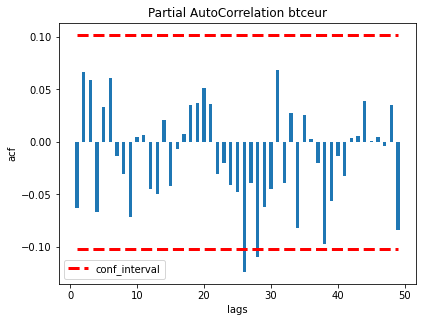

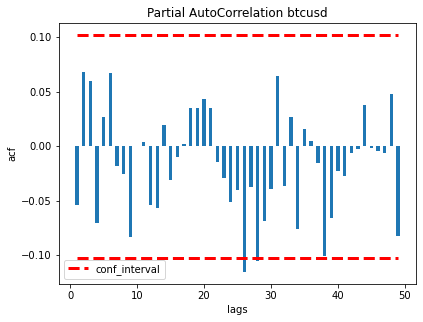

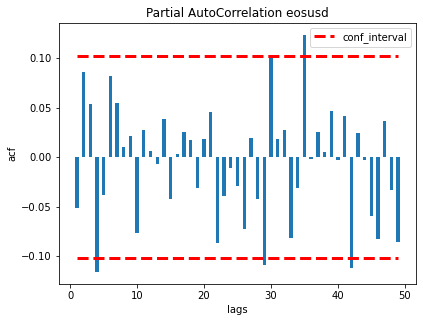

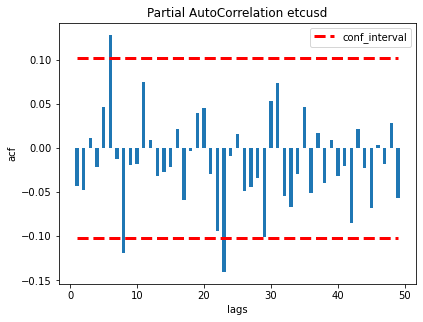

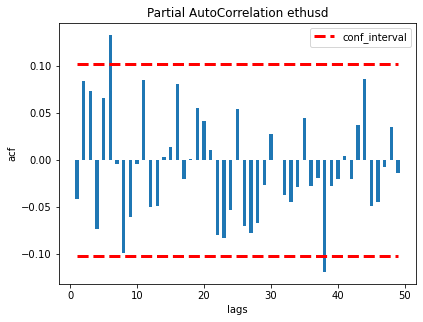

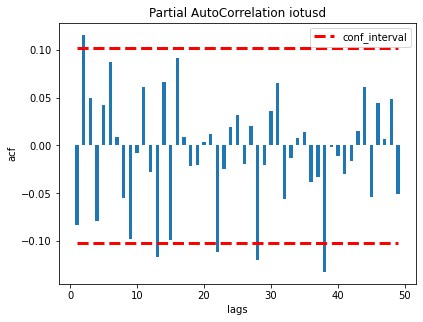

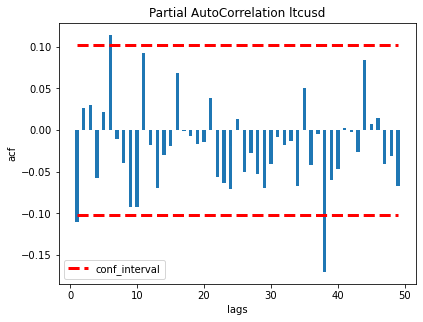

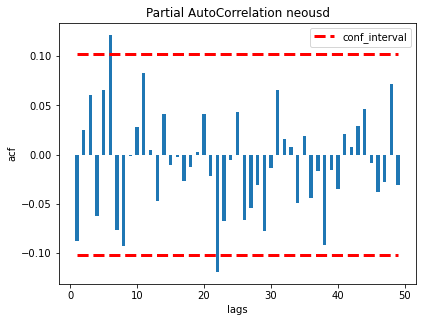

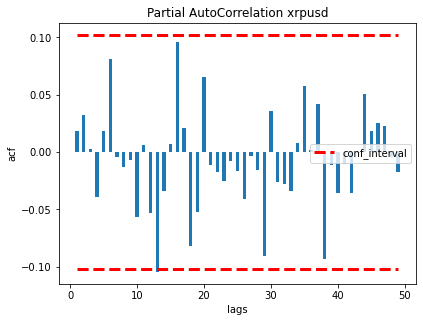

In [18]:
// plaot pacf for all crypto currencies
{.ml.ts.pacfPlot[retTbl x;50;1; string[x]]} each syms;

### Methodology ###

The data set is divided into number of training parts and trading parts on a rolling basis. The training data set uses past one year of data and trading data set contains 1 month of future data. Features are generated for the respective training periods to capture the characteristics of crypto currency pairs. Subsequently the Random Forest Classifier is trained on the training set to make predictions in the sebsequent trading period (1 month in our case). 

We designed following feature sets to estimate direction on the susequent day:

1. 1, 5, 10, 20, 40, 60 and 120 day log return
2. daily return volatility using 10, 20, 40, 60 and 120 days 
3. Volume/20 Day ADV, 20 Day ADV/40 Day ADV, 40 Day ADV/60 Day ADV and 60 Day ADV/120 Day ADV
4. Avg Turnover using 20, 40, 60 and 120 days
5. Volatility of volume using 20, 40, 60 and 120 days

The target set contain the following data:
1. 1 if next day is up day or 0 if next day is down day

In [21]:
// @functionoverview Generates forward 1-day return for specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl} table containing 1-day return keyed by sym and date 
generateTargetData:{[symbol;sd;ed]
  data:select from dailyTbl where sym=symbol;
  data:select sym:symbol, date, retfwd:log xprev[neg 1;close]%close, targetcol:log xprev[neg 1;close]%close from data;
  data:select from data where not null retfwd;
  data:select from data where date within (sd;ed);
  data: `sym`date xkey data;
  :data;};

In [22]:
// @functionoverview Generates classification based on targetcol in the input tbl
// @param targetTbl {tbl} table containing target column
// @returns {tbl} updated input table with classification column 
generateUpDownClassification:{[targetTbl]
 :update class:?[targetcol>0;1;0] from targetTbl;};

In [23]:
// Not used
// @functionoverview Generates classification based on targetcol in the input tbl
// @param targetTbl {tbl} table containing target column
// @returns {tbl} updated input table with classification column based on cross sectional return 
generateCrossSectionalClassification:{[targetTbl]
 toprank: -1 + floor 0.8*count syms;
 :update class:?[toprank < rank targetcol;1;0] by date from targetTbl;};

In [24]:
// @functionoverview Generates feature set for specified symbol wthin start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl} table containing momentum, volatility, volume, turnover features keyed by sym and date 
generateFeaturesData:{[symbol;sd;ed]
  // select price and volume data for the specified symbol
  data:select from dailyTbl where sym=symbol;

  // Add returns for 1,5,10,20,60,120 days
  data:update ret1: (log close%xprev[1;close]),
    ret5:(log close%xprev[5;close]),
    ret10:(log close%xprev[10;close]),
    ret20:(log close%xprev[20;close]),
    ret40:(log close%xprev[40;close]),
    ret60:(log close%xprev[60;close]),
    ret120:(log close%xprev[120;close]) from data;

  // Add 1-day return volatilities for 10,20,40,60,120 days
  data:update std10:mdev[10;ret1], 
    std20:mdev[20;ret1], 
    std40:mdev[40;ret1],
    std60:mdev[60;ret1],
    std120:mdev[120;ret1] from data;

  // Add volume acceleration features
  data:update volumeratio:volume%mavg[20;volume],
    volume20ratio:mavg[20;volume]%mavg[40;volume],
    volume40ratio:mavg[40;volume]%mavg[60;volume],
    volume60ratio:mavg[60;volume]%mavg[120;volume] from data;

  // Add avg turnover 
  data:update turnover20:mavg[20;volume*close],
    turnover40:mavg[60;volume*close],
    turnover60:mavg[80;volume*close],
    turnover120:mavg[120;volume*close] from data;

  //Add volume volatility
  data:update stdvolume20:mdev[20;volume], 
    stdvolume40:mdev[40;volume],
    stdvolume60:mdev[60;volume],
    stdvolume120:mdev[120;volume] from data;
  
  // remove days with null feature values
  data:select from data where not null ret120, not null std120, not null volume60ratio, not null turnover120, not null stdvolume120;
  
  // select dates within the start date and end date range
  data:select from data where date within (sd;ed);

  // Remove all the columns (price and volume) except feature columns
  data:delete open, close, high, low, volume from data;

  // Add sym and date key
  data:`sym`date xkey data;
  :data;};

In [25]:
// @functionoverview Generates dict containing target and feature tabls for both traning and testing set
// @param data {tbl} table containing target and feature columns
// @param splitdt {date} split date for training and testing split
// @returns {dict} returns dict containing target and feature tabls for both traning and testing set
trainTestSplit: {[data;splitdt]
    // Generate training data using date < split date
    trainData:select from data where date < splitdt;
    // delete all columns except feature columns
    xtrain: delete sym, date, retfwd, targetcol, class from trainData;
    xtrain: flip value flip xtrain;
    // populate target with classification
    ytrain: select class from trainData;
    show select count i by class from ytrain;
    ytrain: flip value flip ytrain;
    
     // Generate testing data using date >= split date
    testData:select from data where date >= splitdt;
    // delete all columns except feature columns
    xtest: delete sym, date, retfwd, targetcol, class from testData;
    xtest: flip value flip xtest;
    // populate target with classification
    ytest: select class from testData;
    show select count i by class from ytest;
    ytest: flip value flip ytest;

    //return dictionary containing training and testing data
    :(`xtrain`ytrain`xtest`ytest)!(xtrain;ytrain;xtest;ytest);};

In [26]:
// @functionoverview Generates score for performance comparison for various models
// @param yact {list} actual value of target 
// @param ypred {list} predicted value of target 
// @param yprob {list} probability of all classification 
// @returns {dict} returns dict containing log loss score, accuracy score and roc auc score
score:{[yact;ypred;yprob]
 `loss`acc`auc!(last .ml.logLoss[yact;yprob];last .ml.accuracy[ypred;yact];.ml.rocAucScore[raze yact;yprob[;1]])};

In [31]:
// @functionoverview Trains RF classifier, estimates forecasts for next day, validates the accuracy
// @param syms {list} list of symbol
// @param sd {date} start date of the trading period 
// @param ed {date} end date of the trading period 
// @param trainingDays {int} Number of days before sd to train RF  
// @returns {tbl} table containing date, sym and up probability for the next day
generateSignal:{[syms;sd;ed;trainingDays]
    // Compute training start date starting from 2018.01.01
    trnsd: 2018.01.01|sd-trainingDays;
    
    // Print training and testing periods
    -1 "::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::";
    -1 "Training Start Date: ", string[trnsd], " ", "Trading End Date: ", string[sd-1];
    -1 "Testing Start Date: ", string[sd], " ", "Testing End Date: ", string[ed];
    // Generate target data for all the cyptocurrency
    targetData: (uj/) generateTargetData[;trnsd;ed] each syms;

    // Generate classification based on the target feature is postive or negative
    targetData: generateUpDownClassification[targetData];
    //targetData: generateCrossSectionalClassification[targetData];

    // Generate features data
    featureData: (uj/)generateFeaturesData[;trnsd;ed] each syms;
    
    // remove dates if not present in both target tbl or features tbl
    data:0!ij[targetData;featureData];
    
    //generate training and testing data
    -1 "Training and testing row count: ";
    datadict:trainTestSplit[data;sd];
    show count each datadict;

    //Random forest classifier setting
    name:"Random Forest Classifier";
    ntrees:100;
    clfkwargs:`class_weight`max_depth!(`balanced;5);
    clf:.p.import[`sklearn.ensemble]`:RandomForestClassifier;
    clf:clf[`n_estimators pykw ntrees;pykwargs clfkwargs];
 
    //Random forest fit
    clf[`:fit][xnp:.util.npa datadict`xtrain;datadict`ytrain];
    
    //Probability estimation
    ytrnprob:clf[`:predict_proba;<;xnp];
    ytrnpred:{x?max x} each ytrnprob;
    ytstprob:clf[`:predict_proba;<;.util.npa datadict`xtest];
    ytstpred:{x?max x} each ytstprob;
    
    //Genrate model performance score
    trnscore:score[datadict`ytrain;ytrnpred;ytrnprob];
    tstscore:score[datadict`ytest ;ytstpred;ytstprob];
    
    //Show feature importance
    -1"\n",":Top 10 features:";
    featurecolnames:(cols featureData) except `sym`date;
    show 10#desc (feature:featurecolnames)!(importance:clf[`:feature_importances_]`);
    
    .util.displayROC[raze datadict`ytest;ytstprob[;1]];
    -1 name," (",string[ntrees]," trees)";
    -1 "Training log loss: ",string[trnscore`loss],", accuracy: ",string[trnscore`acc],", ROC: ",string trnscore`auc;
    -1 "Testing  log loss: ",string[tstscore`loss],", accuracy: ",string[tstscore`acc],", ROC: ",string tstscore`auc;
    -1"\n";
    
    signalData: `date`sym xkey select date, sym,  retfwd, probUp:ytstprob[;1] from data where sd <=date;

    :signalData;};


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.01.01 Trading End Date: 2018.12.31
Testing Start Date: 2019.01.01 Testing End Date: 2019.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 1733
1    | 1548
class| x  
-----| ---
0    | 157
1    | 122
xtrain| 3281
ytrain| 3281
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1442547
ret5         | 0.07335898
ret40        | 0.07009614
volume40ratio| 0.05945415
ret120       | 0.05209426
ret20        | 0.04896803
volumeratio  | 0.04754934
std10        | 0.04258161
ret10        | 0.03948588
ret60        | 0.03496569


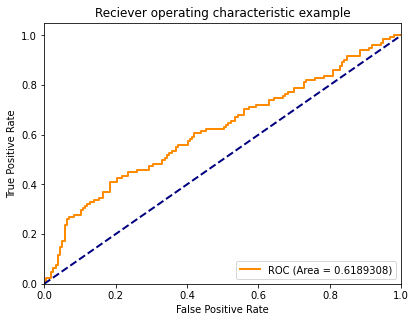

Random Forest Classifier (100 trees)
Training log loss: 0.6411533, accuracy: 0.7031393, ROC: 0.7875281
Testing  log loss: 0.673065, accuracy: 0.6308244, ROC: 0.6189308


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.02.01 Trading End Date: 2019.01.31
Testing Start Date: 2019.02.01 Testing End Date: 2019.02.28
Training and testing row count: 
class| x   
-----| ----
0    | 1754
1    | 1531
class| x  
-----| ---
0    | 104
1    | 148
xtrain| 3285
ytrain| 3285
xtest | 252
ytest | 252

:Top 10 features:
ret1         | 0.1885972
ret40        | 0.07063712
volume40ratio| 0.06860089
ret5         | 0.05540068
ret120       | 0.05369032
ret20        | 0.04704339
std10        | 0.04315794
ret10        | 0.04037498
ret60        | 0.03652847
std20        | 0.03585525


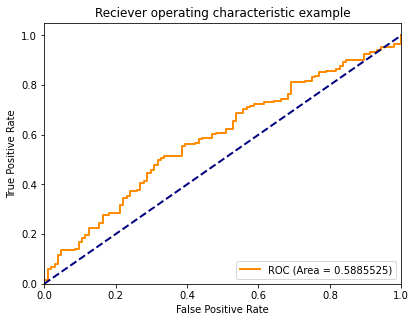

Random Forest Classifier (100 trees)
Training log loss: 0.6361924, accuracy: 0.700761, ROC: 0.7803051
Testing  log loss: 0.7168753, accuracy: 0.4404762, ROC: 0.5885525


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.03.01 Trading End Date: 2019.02.28
Testing Start Date: 2019.03.01 Testing End Date: 2019.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 1737
1    | 1548
class| x  
-----| ---
0    | 139
1    | 140
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2123284
ret120       | 0.07345036
ret40        | 0.05765406
std60        | 0.05577451
volume40ratio| 0.04716699
volumeratio  | 0.04336066
ret5         | 0.04227834
std10        | 0.03766123
ret10        | 0.03379975
std40        | 0.03322193


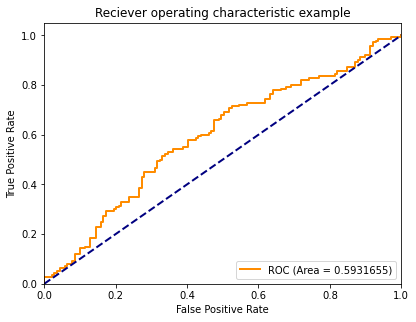

Random Forest Classifier (100 trees)
Training log loss: 0.6386437, accuracy: 0.6894977, ROC: 0.7704028
Testing  log loss: 0.6837861, accuracy: 0.5770609, ROC: 0.5931655


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.04.01 Trading End Date: 2019.03.31
Testing Start Date: 2019.04.01 Testing End Date: 2019.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 1689
1    | 1596
class| x  
-----| ---
0    | 135
1    | 135
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2244808
ret40        | 0.06131065
ret5         | 0.04817436
volume40ratio| 0.04587206
volumeratio  | 0.04571919
ret60        | 0.04440488
std10        | 0.04265724
ret10        | 0.04034626
ret20        | 0.03698117
ret120       | 0.03602797


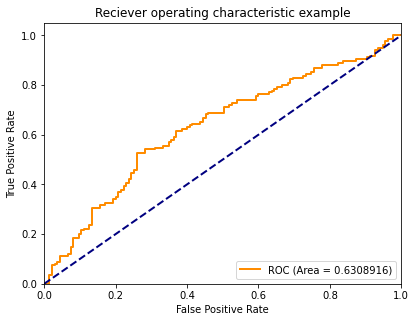

Random Forest Classifier (100 trees)
Training log loss: 0.6375067, accuracy: 0.6898021, ROC: 0.7760201
Testing  log loss: 0.6787422, accuracy: 0.5740741, ROC: 0.6308916


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.05.01 Trading End Date: 2019.04.30
Testing Start Date: 2019.05.01 Testing End Date: 2019.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 1723
1    | 1562
class| x  
-----| ---
0    | 128
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2520972
volume40ratio| 0.05312167
ret5         | 0.05279255
volumeratio  | 0.05163522
ret10        | 0.04192272
ret120       | 0.04152588
ret40        | 0.04133858
ret60        | 0.04034205
ret20        | 0.04029882
std120       | 0.03694244


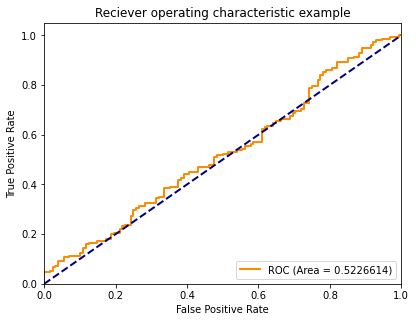

Random Forest Classifier (100 trees)
Training log loss: 0.6351344, accuracy: 0.6958904, ROC: 0.7706924
Testing  log loss: 0.6997427, accuracy: 0.516129, ROC: 0.5226614


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.06.01 Trading End Date: 2019.05.31
Testing Start Date: 2019.06.01 Testing End Date: 2019.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 1693
1    | 1592
class| x  
-----| ---
0    | 112
1    | 158
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2218589
ret5         | 0.05055494
volumeratio  | 0.04971503
ret60        | 0.04707432
std60        | 0.04341325
ret10        | 0.04330903
ret20        | 0.04309581
ret40        | 0.04257842
ret120       | 0.03992477
volume40ratio| 0.0397234


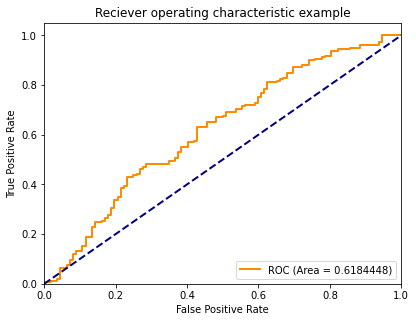

Random Forest Classifier (100 trees)
Training log loss: 0.6348822, accuracy: 0.6977169, ROC: 0.7724149
Testing  log loss: 0.6779717, accuracy: 0.5555556, ROC: 0.6184448


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.07.01 Trading End Date: 2019.06.30
Testing Start Date: 2019.07.01 Testing End Date: 2019.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 1665
1    | 1620
class| x  
-----| ---
0    | 143
1    | 136
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2049224
ret60        | 0.0656594
ret10        | 0.0533861
ret20        | 0.04854156
volumeratio  | 0.0481251
volume40ratio| 0.04754364
std120       | 0.04500872
ret5         | 0.04448346
std60        | 0.03951156
ret40        | 0.03878828


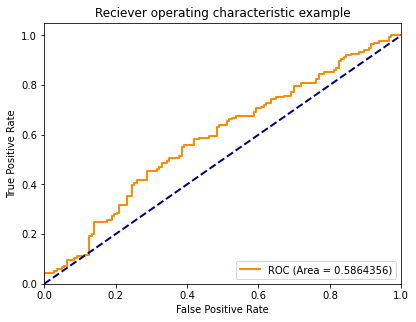

Random Forest Classifier (100 trees)
Training log loss: 0.6348335, accuracy: 0.6983257, ROC: 0.7740214
Testing  log loss: 0.6827145, accuracy: 0.5770609, ROC: 0.5864356


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.08.01 Trading End Date: 2019.07.31
Testing Start Date: 2019.08.01 Testing End Date: 2019.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 1655
1    | 1630
class| x  
-----| ---
0    | 154
1    | 125
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2073534
ret5         | 0.06661905
ret60        | 0.06045371
volume40ratio| 0.05635926
ret20        | 0.05119838
ret40        | 0.0467185
ret10        | 0.04500864
ret120       | 0.04380935
volumeratio  | 0.03874501
std10        | 0.03471876


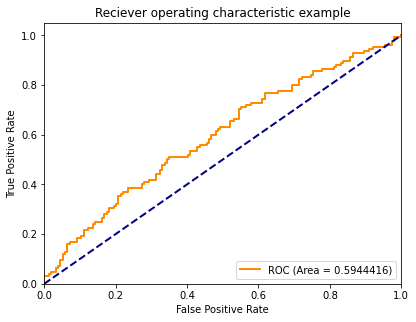

Random Forest Classifier (100 trees)
Training log loss: 0.6366293, accuracy: 0.6940639, ROC: 0.7708046
Testing  log loss: 0.6821817, accuracy: 0.562724, ROC: 0.5944416


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.09.01 Trading End Date: 2019.08.31
Testing Start Date: 2019.09.01 Testing End Date: 2019.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 1662
1    | 1623
class| x  
-----| ---
0    | 150
1    | 120
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1945609
ret5         | 0.06701991
ret10        | 0.05775452
ret60        | 0.05418362
volume40ratio| 0.05227729
ret20        | 0.05180104
volumeratio  | 0.04587001
ret40        | 0.04395576
std10        | 0.04125583
ret120       | 0.04048089


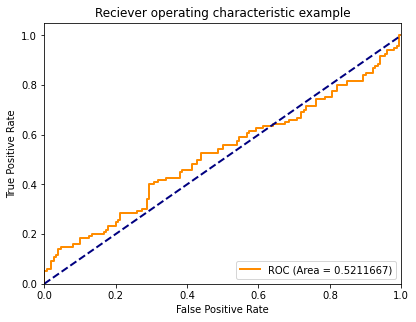

Random Forest Classifier (100 trees)
Training log loss: 0.6364226, accuracy: 0.6971081, ROC: 0.7717335
Testing  log loss: 0.6913996, accuracy: 0.5407407, ROC: 0.5211667


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.10.01 Trading End Date: 2019.09.30
Testing Start Date: 2019.10.01 Testing End Date: 2019.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 1667
1    | 1618
class| x  
-----| ---
0    | 139
1    | 140
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1854307
ret5         | 0.07450564
ret10        | 0.06717084
ret60        | 0.06436548
volume40ratio| 0.05605853
ret20        | 0.05241087
std10        | 0.04273469
ret40        | 0.04227342
ret120       | 0.03954193
volumeratio  | 0.0370452


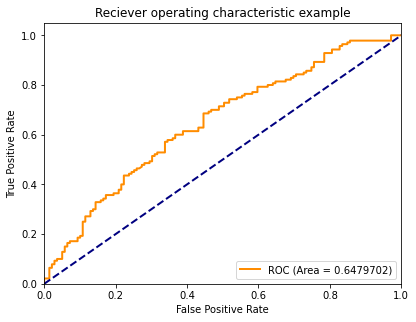

Random Forest Classifier (100 trees)
Training log loss: 0.6356692, accuracy: 0.7001522, ROC: 0.7801414
Testing  log loss: 0.6761473, accuracy: 0.5842294, ROC: 0.6479702


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.11.01 Trading End Date: 2019.10.31
Testing Start Date: 2019.11.01 Testing End Date: 2019.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 1655
1    | 1630
class| x  
-----| ---
0    | 149
1    | 121
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2129412
ret5         | 0.057181
volume40ratio| 0.05583507
ret60        | 0.05485667
ret10        | 0.05306982
ret20        | 0.0529992
std120       | 0.04839189
volumeratio  | 0.04737768
std10        | 0.04579388
ret120       | 0.04076853


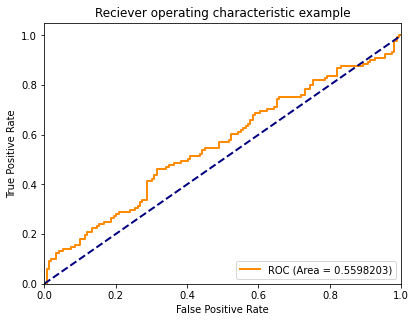

Random Forest Classifier (100 trees)
Training log loss: 0.6337089, accuracy: 0.6986301, ROC: 0.7755361
Testing  log loss: 0.6904822, accuracy: 0.5259259, ROC: 0.5598203


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.12.01 Trading End Date: 2019.11.30
Testing Start Date: 2019.12.01 Testing End Date: 2019.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 1652
1    | 1633
class| x  
-----| ---
0    | 149
1    | 130
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2260941
ret5         | 0.06788717
volume40ratio| 0.05676361
ret10        | 0.05668781
ret60        | 0.05273307
ret20        | 0.04931416
ret120       | 0.04795515
std20        | 0.04339996
std120       | 0.03606396
std10        | 0.03595312


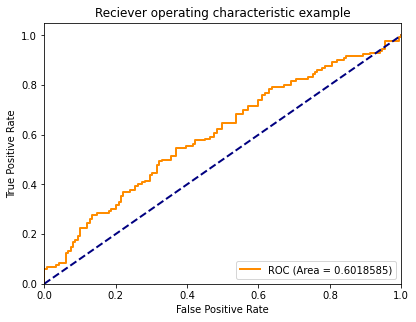

Random Forest Classifier (100 trees)
Training log loss: 0.6337416, accuracy: 0.6980213, ROC: 0.7684349
Testing  log loss: 0.6789022, accuracy: 0.5842294, ROC: 0.6018585


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.01.01 Trading End Date: 2019.12.31
Testing Start Date: 2020.01.01 Testing End Date: 2020.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 1659
1    | 1626
class| x  
-----| ---
0    | 121
1    | 158
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1911178
ret10        | 0.083306
ret20        | 0.06806472
ret5         | 0.05751282
ret60        | 0.05330652
ret120       | 0.04941785
volume40ratio| 0.04551
ret40        | 0.04538836
std20        | 0.03958947
volumeratio  | 0.03762431


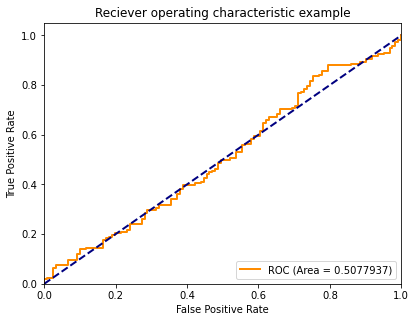

Random Forest Classifier (100 trees)
Training log loss: 0.635404, accuracy: 0.6894977, ROC: 0.7727458
Testing  log loss: 0.7086039, accuracy: 0.4659498, ROC: 0.5077937


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.02.01 Trading End Date: 2020.01.31
Testing Start Date: 2020.02.01 Testing End Date: 2020.02.29
Training and testing row count: 
class| x   
-----| ----
0    | 1623
1    | 1662
class| x  
-----| ---
0    | 130
1    | 131
xtrain| 3285
ytrain| 3285
xtest | 261
ytest | 261

:Top 10 features:
ret1         | 0.1554787
ret10        | 0.0902094
ret5         | 0.06256193
ret20        | 0.06199048
std20        | 0.05844428
ret120       | 0.05080449
std10        | 0.05057066
volume40ratio| 0.04155904
volumeratio  | 0.04042948
std120       | 0.04009454


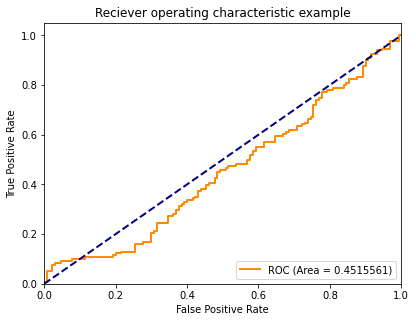

Random Forest Classifier (100 trees)
Training log loss: 0.6394015, accuracy: 0.699239, ROC: 0.7836145
Testing  log loss: 0.7123952, accuracy: 0.4636015, ROC: 0.4515561


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.03.02 Trading End Date: 2020.02.29
Testing Start Date: 2020.03.01 Testing End Date: 2020.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 1643
1    | 1642
class| x  
-----| ---
0    | 129
1    | 150
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1329675
ret10        | 0.07069589
ret5         | 0.0627868
std20        | 0.05853446
ret20        | 0.05775149
volumeratio  | 0.05665343
ret60        | 0.04992433
volume40ratio| 0.04775838
ret120       | 0.04211336
std120       | 0.03888133


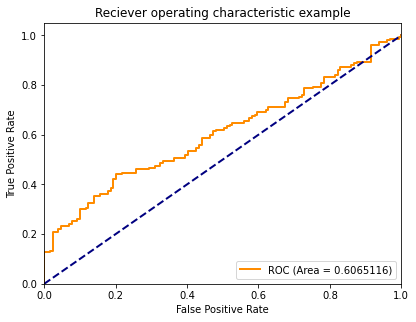

Random Forest Classifier (100 trees)
Training log loss: 0.6432211, accuracy: 0.6922374, ROC: 0.7779622
Testing  log loss: 0.6655417, accuracy: 0.5663082, ROC: 0.6065116


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.04.02 Trading End Date: 2020.03.31
Testing Start Date: 2020.04.01 Testing End Date: 2020.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 1639
1    | 1646
class| x  
-----| ---
0    | 114
1    | 156
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1362872
ret10        | 0.08013988
ret5         | 0.06414268
ret20        | 0.06254549
ret40        | 0.05882901
std20        | 0.05562525
ret60        | 0.05035144
std40        | 0.04964979
std10        | 0.0492767
volume40ratio| 0.04104751


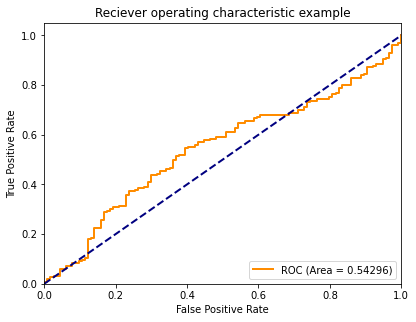

Random Forest Classifier (100 trees)
Training log loss: 0.6385048, accuracy: 0.7035008, ROC: 0.7798724
Testing  log loss: 0.6967987, accuracy: 0.5296296, ROC: 0.54296


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.05.02 Trading End Date: 2020.04.30
Testing Start Date: 2020.05.01 Testing End Date: 2020.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 1614
1    | 1671
class| x  
-----| ---
0    | 130
1    | 149
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1655667
ret40        | 0.0897708
std20        | 0.0729337
ret20        | 0.06064382
ret5         | 0.05774846
ret10        | 0.05603766
ret60        | 0.05303135
volume20ratio| 0.04280306
volumeratio  | 0.03951053
std10        | 0.03922742


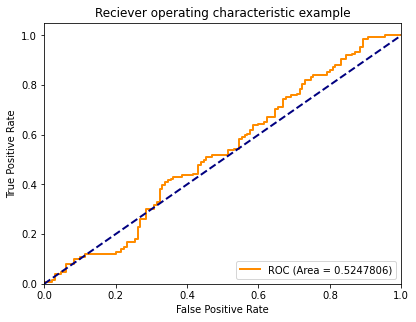

Random Forest Classifier (100 trees)
Training log loss: 0.6331473, accuracy: 0.6964992, ROC: 0.7811983
Testing  log loss: 0.6905471, accuracy: 0.5591398, ROC: 0.5247806


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.06.02 Trading End Date: 2020.05.31
Testing Start Date: 2020.06.01 Testing End Date: 2020.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 1620
1    | 1665
class| x  
-----| ---
0    | 145
1    | 125
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1565031
ret40        | 0.07759736
ret5         | 0.07354657
std20        | 0.07286468
ret10        | 0.06118141
std10        | 0.05919208
ret60        | 0.04920272
std40        | 0.04809277
ret20        | 0.04565081
volume20ratio| 0.03683148


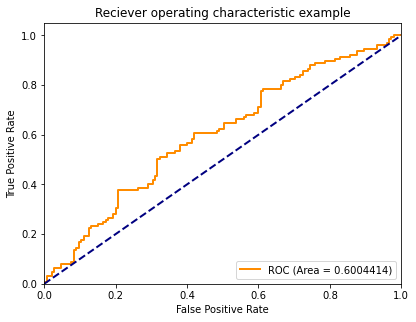

Random Forest Classifier (100 trees)
Training log loss: 0.6342754, accuracy: 0.7059361, ROC: 0.7907433
Testing  log loss: 0.6775214, accuracy: 0.5851852, ROC: 0.6004414


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.07.02 Trading End Date: 2020.06.30
Testing Start Date: 2020.07.01 Testing End Date: 2020.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 1647
1    | 1638
class| x  
-----| ---
0    | 122
1    | 157
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1549554
ret40        | 0.09218632
ret5         | 0.07988765
std20        | 0.06831569
ret10        | 0.06547206
ret20        | 0.05308345
ret60        | 0.0456476
volume20ratio| 0.04427748
std10        | 0.04265748
std40        | 0.03719367


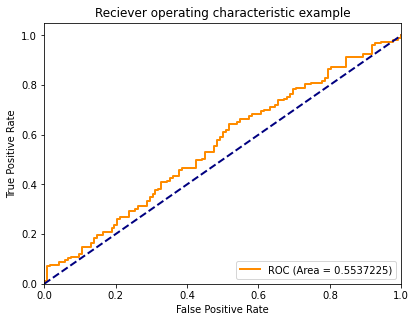

Random Forest Classifier (100 trees)
Training log loss: 0.6304853, accuracy: 0.7068493, ROC: 0.793186
Testing  log loss: 0.7280491, accuracy: 0.4695341, ROC: 0.5537225


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.08.02 Trading End Date: 2020.07.31
Testing Start Date: 2020.08.01 Testing End Date: 2020.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 1625
1    | 1660
class| x  
-----| ---
0    | 125
1    | 154
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1561396
ret40        | 0.09507533
ret5         | 0.07195316
ret10        | 0.06498311
std20        | 0.05625504
ret60        | 0.05099512
volume20ratio| 0.04733833
ret20        | 0.04723595
std120       | 0.04031301
ret120       | 0.03778855


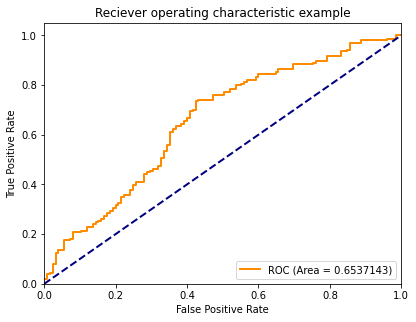

Random Forest Classifier (100 trees)
Training log loss: 0.6350873, accuracy: 0.7108067, ROC: 0.7917372
Testing  log loss: 0.6703802, accuracy: 0.5842294, ROC: 0.6537143


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.09.02 Trading End Date: 2020.08.31
Testing Start Date: 2020.09.01 Testing End Date: 2020.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 1603
1    | 1682
class| x  
-----| ---
0    | 130
1    | 140
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2010809
ret40        | 0.08043079
ret5         | 0.07537413
volume20ratio| 0.06323545
ret60        | 0.0497721
ret10        | 0.04891316
std20        | 0.04540399
ret20        | 0.04214558
std10        | 0.03942537
volumeratio  | 0.03627383


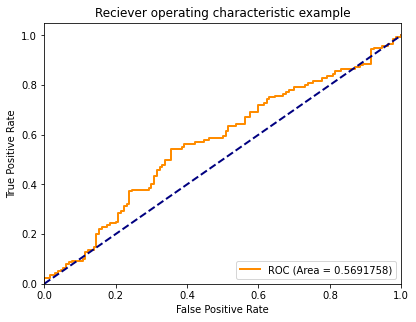

Random Forest Classifier (100 trees)
Training log loss: 0.6314177, accuracy: 0.7092846, ROC: 0.7832616
Testing  log loss: 0.6897155, accuracy: 0.5703704, ROC: 0.5691758


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.10.02 Trading End Date: 2020.09.30
Testing Start Date: 2020.10.01 Testing End Date: 2020.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 1583
1    | 1702
class| x  
-----| ---
0    | 128
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.228407
ret5         | 0.0861154
ret40        | 0.07341761
volume20ratio| 0.04908516
ret60        | 0.04806059
ret10        | 0.04581078
std20        | 0.03919222
ret20        | 0.03731734
std10        | 0.03634571
volumeratio  | 0.03466766


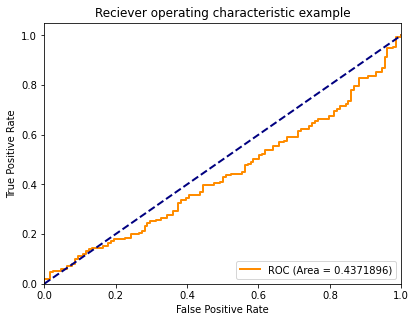

Random Forest Classifier (100 trees)
Training log loss: 0.6302801, accuracy: 0.6949772, ROC: 0.7812226
Testing  log loss: 0.7204884, accuracy: 0.4551971, ROC: 0.4371896


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.11.02 Trading End Date: 2020.10.31
Testing Start Date: 2020.11.01 Testing End Date: 2020.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 1568
1    | 1717
class| x  
-----| ---
0    | 119
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2112776
ret5         | 0.07092679
ret40        | 0.06791464
ret10        | 0.05272475
ret60        | 0.05211226
std10        | 0.04502145
volume20ratio| 0.04314719
ret20        | 0.04182141
std20        | 0.03796359
std40        | 0.03634934


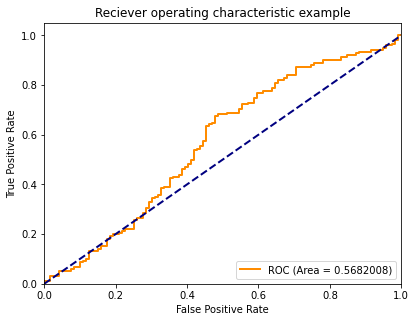

Random Forest Classifier (100 trees)
Training log loss: 0.6369579, accuracy: 0.6782344, ROC: 0.7728452
Testing  log loss: 0.690269, accuracy: 0.5259259, ROC: 0.5682008


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.12.02 Trading End Date: 2020.11.30
Testing Start Date: 2020.12.01 Testing End Date: 2020.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 1534
1    | 1751
class| x  
-----| ---
0    | 125
1    | 154
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.198063
ret40        | 0.07085746
ret5         | 0.06742427
ret10        | 0.05649348
ret60        | 0.05574386
volume20ratio| 0.05020105
ret20        | 0.04554322
volumeratio  | 0.04218702
std10        | 0.03930972
volume60ratio| 0.03645995


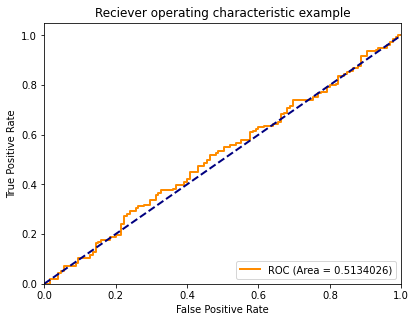

Random Forest Classifier (100 trees)
Training log loss: 0.6413219, accuracy: 0.674277, ROC: 0.7690122
Testing  log loss: 0.6972759, accuracy: 0.5197133, ROC: 0.5134026


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.01.02 Trading End Date: 2020.12.31
Testing Start Date: 2021.01.01 Testing End Date: 2021.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 1509
1    | 1776
class| x  
-----| ---
0    | 123
1    | 156
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.173781
ret40        | 0.07094342
ret5         | 0.06378035
ret60        | 0.05623188
ret10        | 0.0501599
volume20ratio| 0.04828347
volume60ratio| 0.04518882
ret120       | 0.04269465
ret20        | 0.04050071
std40        | 0.03932852


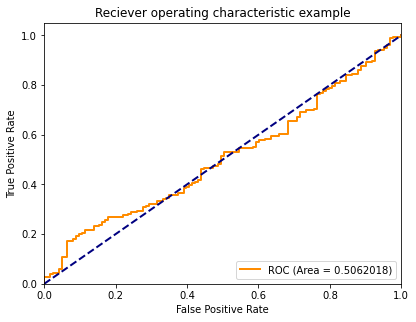

Random Forest Classifier (100 trees)
Training log loss: 0.6413286, accuracy: 0.6940639, ROC: 0.7860278
Testing  log loss: 0.6977199, accuracy: 0.483871, ROC: 0.5062018


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.02.02 Trading End Date: 2021.01.31
Testing Start Date: 2021.02.01 Testing End Date: 2021.02.28
Training and testing row count: 
class| x   
-----| ----
0    | 1516
1    | 1769
class| x  
-----| ---
0    | 111
1    | 141
xtrain| 3285
ytrain| 3285
xtest | 252
ytest | 252

:Top 10 features:
ret1         | 0.1926371
ret5         | 0.07105963
ret40        | 0.0644775
volume40ratio| 0.04800852
ret10        | 0.04731011
volume60ratio| 0.04117642
ret120       | 0.03950768
ret60        | 0.03811921
std10        | 0.0370765
std120       | 0.03552135


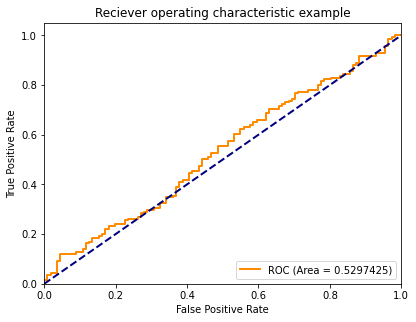

Random Forest Classifier (100 trees)
Training log loss: 0.6438082, accuracy: 0.6834094, ROC: 0.7660478
Testing  log loss: 0.6997755, accuracy: 0.468254, ROC: 0.5297425


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.03.01 Trading End Date: 2021.02.28
Testing Start Date: 2021.03.01 Testing End Date: 2021.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 1501
1    | 1784
class| x  
-----| ---
0    | 116
1    | 163
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1936789
ret5         | 0.06752175
ret40        | 0.05461221
ret10        | 0.04691356
ret60        | 0.0454021
volume60ratio| 0.04364099
std10        | 0.04176866
volume40ratio| 0.04093767
volume20ratio| 0.04041782
ret20        | 0.0403226


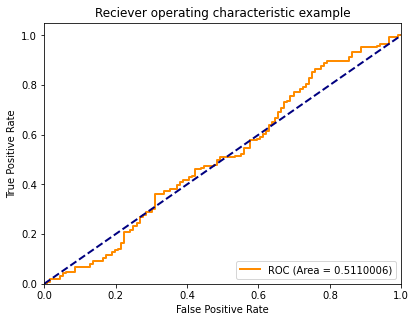

Random Forest Classifier (100 trees)
Training log loss: 0.6423157, accuracy: 0.6797565, ROC: 0.7697236
Testing  log loss: 0.699683, accuracy: 0.4910394, ROC: 0.5110006


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.04.01 Trading End Date: 2021.03.31
Testing Start Date: 2021.04.01 Testing End Date: 2021.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 1488
1    | 1797
class| x  
-----| ---
0    | 125
1    | 145
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1807674
ret5         | 0.06690155
ret40        | 0.0486265
volume60ratio| 0.04660113
std40        | 0.04520697
volume40ratio| 0.04422164
ret20        | 0.04272028
std20        | 0.04080845
ret60        | 0.03886819
ret10        | 0.03761818


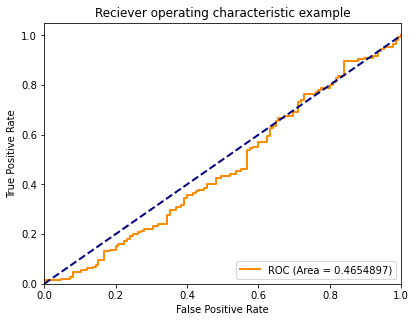

Random Forest Classifier (100 trees)
Training log loss: 0.6459068, accuracy: 0.6700152, ROC: 0.7709809
Testing  log loss: 0.7109711, accuracy: 0.4666667, ROC: 0.4654897


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.05.01 Trading End Date: 2021.04.30
Testing Start Date: 2021.05.01 Testing End Date: 2021.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 1499
1    | 1786
class| x  
-----| ---
0    | 151
1    | 128
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1439345
ret5         | 0.05918059
ret40        | 0.05807061
ret60        | 0.04784644
std120       | 0.04697952
std20        | 0.04556092
std10        | 0.04321714
std60        | 0.04155203
volume40ratio| 0.04079264
ret120       | 0.04065999


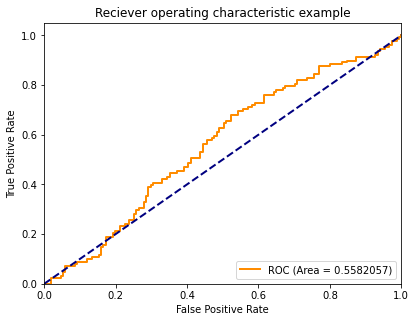

Random Forest Classifier (100 trees)
Training log loss: 0.6453962, accuracy: 0.6943683, ROC: 0.777503
Testing  log loss: 0.6918961, accuracy: 0.5663082, ROC: 0.5582057


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.06.01 Trading End Date: 2021.05.31
Testing Start Date: 2021.06.01 Testing End Date: 2021.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 1520
1    | 1765
class| x  
-----| ---
0    | 138
1    | 132
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1713746
ret40        | 0.05074172
ret5         | 0.04860682
std10        | 0.04684901
ret120       | 0.04580468
volume20ratio| 0.04423726
volume60ratio| 0.04103755
std20        | 0.0409212
volume40ratio| 0.04029955
std120       | 0.04027732


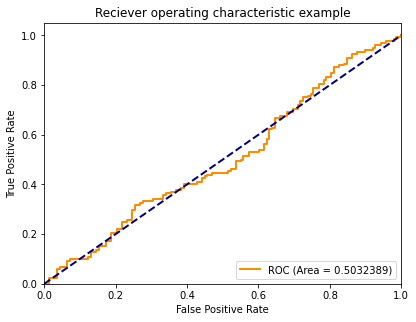

Random Forest Classifier (100 trees)
Training log loss: 0.6471533, accuracy: 0.674277, ROC: 0.753725
Testing  log loss: 0.6987351, accuracy: 0.4925926, ROC: 0.5032389


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.07.01 Trading End Date: 2021.06.30
Testing Start Date: 2021.07.01 Testing End Date: 2021.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 1513
1    | 1772
class| x  
-----| ---
0    | 126
1    | 153
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1421512
ret5         | 0.05749876
std20        | 0.0533295
ret40        | 0.05029555
ret20        | 0.04779317
std10        | 0.04762297
ret60        | 0.04411539
volume20ratio| 0.04251652
std120       | 0.0415115
volume40ratio| 0.04058989


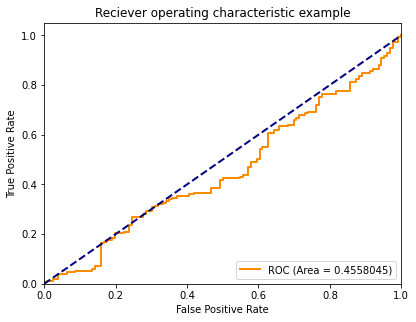

Random Forest Classifier (100 trees)
Training log loss: 0.6502087, accuracy: 0.7004566, ROC: 0.7694488
Testing  log loss: 0.7010514, accuracy: 0.4551971, ROC: 0.4558045


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.08.01 Trading End Date: 2021.07.31
Testing Start Date: 2021.08.01 Testing End Date: 2021.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 1517
1    | 1768
class| x  
-----| ---
0    | 117
1    | 162
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.114671
ret5         | 0.06360253
ret20        | 0.05124336
volume20ratio| 0.04956464
std20        | 0.04917417
ret60        | 0.04809057
std60        | 0.04602259
volume40ratio| 0.04456644
std40        | 0.04311534
ret10        | 0.04149382


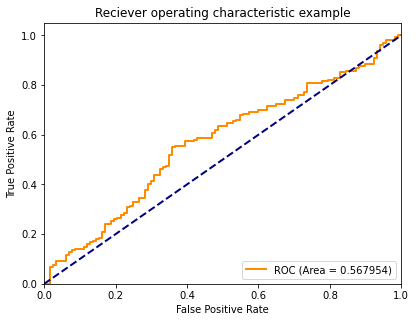

Random Forest Classifier (100 trees)
Training log loss: 0.6507545, accuracy: 0.6925419, ROC: 0.7697252
Testing  log loss: 0.6798229, accuracy: 0.5519713, ROC: 0.567954


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.09.01 Trading End Date: 2021.08.31
Testing Start Date: 2021.09.01 Testing End Date: 2021.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 1509
1    | 1776
class| x  
-----| ---
0    | 139
1    | 131
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1111088
std60        | 0.05807322
std20        | 0.0549942
volume40ratio| 0.05386573
ret40        | 0.0515602
ret5         | 0.04777091
ret10        | 0.04681076
ret60        | 0.04516562
std40        | 0.045043
ret20        | 0.04327689


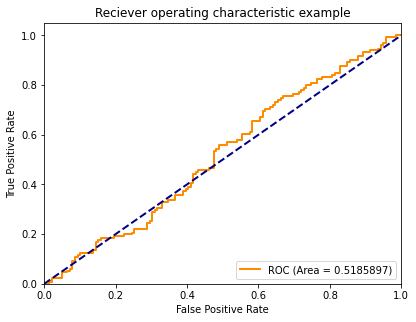

Random Forest Classifier (100 trees)
Training log loss: 0.6498841, accuracy: 0.6925419, ROC: 0.7636366
Testing  log loss: 0.6975389, accuracy: 0.5333333, ROC: 0.5185897


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.10.01 Trading End Date: 2021.09.30
Testing Start Date: 2021.10.01 Testing End Date: 2021.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 1518
1    | 1767
class| x  
-----| ---
0    | 128
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.08541017
ret5         | 0.06886411
std20        | 0.0687041
volumeratio  | 0.0559149
std40        | 0.04921921
volume20ratio| 0.04849818
ret40        | 0.04848975
ret60        | 0.04843248
std60        | 0.04840834
ret10        | 0.04696183


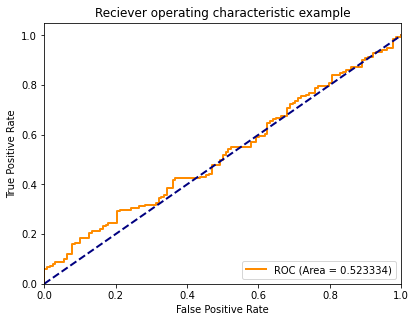

Random Forest Classifier (100 trees)
Training log loss: 0.6497548, accuracy: 0.6934551, ROC: 0.7743117
Testing  log loss: 0.6892555, accuracy: 0.5376344, ROC: 0.523334


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.11.01 Trading End Date: 2021.10.31
Testing Start Date: 2021.11.01 Testing End Date: 2021.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 1518
1    | 1767
class| x  
-----| ---
0    | 129
1    | 141
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1129407
std20        | 0.06045138
ret5         | 0.05993504
std60        | 0.05634499
std10        | 0.05259021
volumeratio  | 0.0519048
ret20        | 0.04929292
volume20ratio| 0.04861731
ret40        | 0.04210297
volume40ratio| 0.04177406


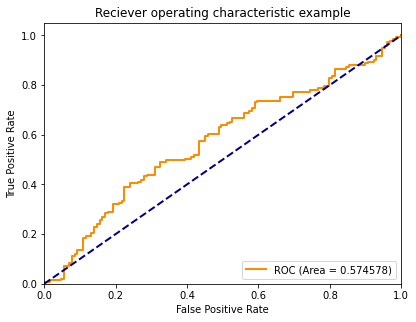

Random Forest Classifier (100 trees)
Training log loss: 0.6504, accuracy: 0.6998478, ROC: 0.7752408
Testing  log loss: 0.6857899, accuracy: 0.537037, ROC: 0.574578


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.12.01 Trading End Date: 2021.11.30
Testing Start Date: 2021.12.01 Testing End Date: 2021.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 1528
1    | 1757
class| x  
-----| ---
0    | 146
1    | 133
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1       | 0.09929946
volumeratio| 0.07347407
std20      | 0.06042999
ret5       | 0.0550628
std60      | 0.05219372
ret120     | 0.04943359
ret40      | 0.04614694
ret20      | 0.04477595
std10      | 0.04295843
ret10      | 0.04198739


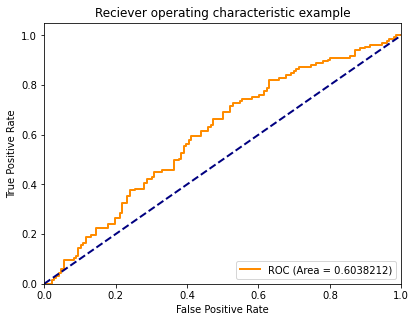

Random Forest Classifier (100 trees)
Training log loss: 0.6478473, accuracy: 0.6961948, ROC: 0.7831002
Testing  log loss: 0.6892448, accuracy: 0.562724, ROC: 0.6038212


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2021.01.01 Trading End Date: 2021.12.31
Testing Start Date: 2022.01.01 Testing End Date: 2022.01.16
Training and testing row count: 
class| x   
-----| ----
0    | 1549
1    | 1736
class| x 
-----| --
0    | 71
1    | 64
xtrain| 3285
ytrain| 3285
xtest | 135
ytest | 135

:Top 10 features:
ret1         | 0.1140918
volumeratio  | 0.07226605
std20        | 0.06003339
std60        | 0.05312304
ret5         | 0.05271918
volume20ratio| 0.05093985
std10        | 0.05064848
ret40        | 0.04245675
ret120       | 0.04167296
ret20        | 0.0390408


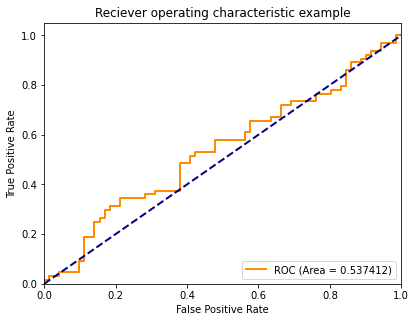

Random Forest Classifier (100 trees)
Training log loss: 0.6489997, accuracy: 0.6952816, ROC: 0.7737019
Testing  log loss: 0.6948884, accuracy: 0.5111111, ROC: 0.537412




In [32]:
// run backtest to generate signal
// Generate tbl of inputs (list of sym, sd, ed, trainingDays) to call signal generation
backtestTbl: 0!select syms:syms, sd:first date, ed:last date by `month$date, trainingDays:365 from dailyTbl where date >= 2019.01.01;
// Call the signal generation
signalTbl: (uj/) {generateSignal[x[`syms];x[`sd];x[`ed];x[`trainingDays]]} each backtestTbl;

In [33]:
// @functionoverview Generate pnl stats
// @param signalTbl {tbl} signal table
// @returns {tbl} backtest pnl stats and equity curve
getPnlSummary:{[signalTbl]
    signalTbl:update pos:?[0.52<probUp;1;?[0.48>probUp;-1;0]] by date from signalTbl;
    dailypnlTbl:select totalret:sum pos*retfwd, nassetlong: sum ?[0<pos;1;0], nassetshort: sum ?[pos<0;1;0] by date from signalTbl;
    dailypnlTbl:update nasset: nassetlong + nassetshort from dailypnlTbl;
    dailypnlTbl:update ret: totalret%nasset from dailypnlTbl;
    show select avgret: avg ret, 
        sdret: dev ret, 
        sharperatio: (avg ret)*sqrt(252)%dev ret, 
        minret:min ret, 
        maxret:max ret from dailypnlTbl;
    .util.plotTimeSeriesSubplots[exec date from dailypnlTbl;exec sums ret from dailypnlTbl;"cumulative pnl"];};

In [223]:
// Not used
getPnlSummaryCrossSectional:{[signalTbl]
    toprank: -1 + floor 0.8*count syms;
    bottomrank: -1 + (count syms) - toprank;
    signalTbl:update pos:?[toprank<rank probUp;1;?[bottomrank>rank probUp;-1;0]] by date from signalTbl;
    dailypnlTbl:select totalret:sum pos*retfwd, nassetlong: sum ?[0<pos;1;0], nassetshort: sum ?[pos<0;1;0] by date from signalTbl;
    dailypnlTbl:update nasset: nassetlong + nassetshort from dailypnlTbl;
    dailypnlTbl:update ret: totalret%nasset from dailypnlTbl;
    show dailypnlTbl;
    show select avgret: avg ret, 
        sdret: dev ret, 
        sharperatio: (avg ret)*sqrt(252)%dev ret, 
        minret:min ret, 
        maxret:max ret from dailypnlTbl;
    .util.plotTimeSeriesSubplots[exec date from dailypnlTbl;exec sums ret from dailypnlTbl;"cumulative pnl"];};

avgret      sdret      sharperatio minret     maxret   
-------------------------------------------------------
0.001139498 0.03961501 0.09088329  -0.2470536 0.2884105


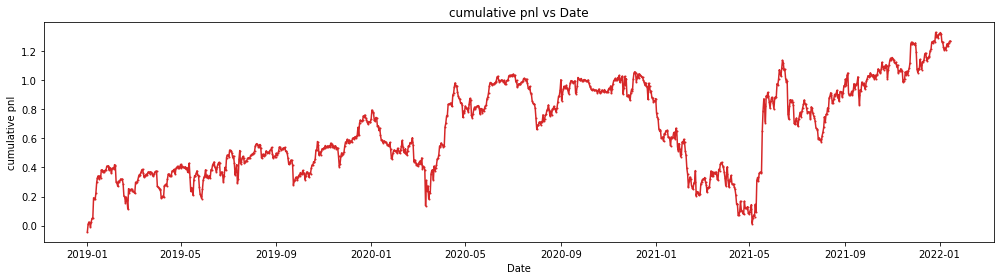

In [34]:
getPnlSummary[signalTbl]